In [17]:
import re
import string
import emoji
from unidecode import unidecode
import pandas as pd 
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import joblib
from scipy import sparse
from concurrent.futures import ThreadPoolExecutor
import functools
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from wordcloud import WordCloud

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\VICTUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VICTUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\VICTUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
data = pd.read_csv('cnn_indonesia_berita_10_pages.csv')
data.head()

title  \
0  Sumardji Bantah Simon Tahamata Jadi Kepala Sco...   
1  Pengamat Sebut Absennya Pemain Persib di Timna...   
2  Tiket Timnas Indonesia vs ChinaSold OutTanpa T...   
3  Timnas Futsal Indonesia Ingin Jajal Belanda da...   
4  Pengamat: Tak Perlu Ributkan Elkan Baggott di ...   

                                                link  category  \
0  https://www.cnnindonesia.com/olahraga/20250519...  olahraga   
1  https://www.cnnindonesia.com/olahraga/20250519...  olahraga   
2  https://www.cnnindonesia.com/olahraga/20250519...  olahraga   
3  https://www.cnnindonesia.com/olahraga/20250519...  olahraga   
4  https://www.cnnindonesia.com/olahraga/20250519...  olahraga   

                                             content  date  
0  Ketua Badan Tim Nasional (BTN) Sumardji memban...   NaN  
1  Pengamat sepak bola nasional Supriyono Prima m...   NaN  
2  TiketTimnas Indonesia vs Chinadalam lanjutan K...   NaN  
3  Timnas Futsal Indonesiamengincar kesempatan be...   NaN  
4  Pengamat sepak bola nasional Supriyono Prima m...   NaN

In [3]:
data['text'] = data['title'] + ' ' + data['content']

In [4]:
filtered_data = data[~data['title'].str.contains('FOTO:', na=False)].reset_index(drop=True)
filtered_data.head()

title  \
0  Sumardji Bantah Simon Tahamata Jadi Kepala Sco...   
1  Pengamat Sebut Absennya Pemain Persib di Timna...   
2  Tiket Timnas Indonesia vs ChinaSold OutTanpa T...   
3  Timnas Futsal Indonesia Ingin Jajal Belanda da...   
4  Pengamat: Tak Perlu Ributkan Elkan Baggott di ...   

                                                link  category  \
0  https://www.cnnindonesia.com/olahraga/20250519...  olahraga   
1  https://www.cnnindonesia.com/olahraga/20250519...  olahraga   
2  https://www.cnnindonesia.com/olahraga/20250519...  olahraga   
3  https://www.cnnindonesia.com/olahraga/20250519...  olahraga   
4  https://www.cnnindonesia.com/olahraga/20250519...  olahraga   

                                             content  date  \
0  Ketua Badan Tim Nasional (BTN) Sumardji memban...   NaN   
1  Pengamat sepak bola nasional Supriyono Prima m...   NaN   
2  TiketTimnas Indonesia vs Chinadalam lanjutan K...   NaN   
3  Timnas Futsal Indonesiamengincar kesempatan be...   NaN   
4  Pengamat sepak bola nasional Supriyono Prima m...   NaN   

                                                text  
0  Sumardji Bantah Simon Tahamata Jadi Kepala Sco...  
1  Pengamat Sebut Absennya Pemain Persib di Timna...  
2  Tiket Timnas Indonesia vs ChinaSold OutTanpa T...  
3  Timnas Futsal Indonesia Ingin Jajal Belanda da...  
4  Pengamat: Tak Perlu Ributkan Elkan Baggott di ...

In [5]:
import random

sample = filtered_data.groupby('category', group_keys=False).apply(
    lambda x: x.sample(n=random.randint(25, 35), random_state=42)
).reset_index(drop=True)

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_16356\1200955838.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = filtered_data.groupby('category', group_keys=False).apply(


Model partitioning KMeans DBCSAN

In [6]:
print(f"Total data: {sample.shape[0]}")

Total data: 189


In [8]:

def clean_text(text: str):
    try:
        stop_factory = StopWordRemoverFactory()
        STOP_WORDS = set(stop_factory.get_stop_words())
        # lemmatizer = WordNetLemmatizer()
        factory = StemmerFactory()
        stemmer = factory.create_stemmer()
        
        if not text:
            return ""

        text = text.lower()
        text = unidecode(text).lower()  # Normalize unicode characters
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
        text = re.sub(r'@\w+|#\w+', '', text)  # Remove mentions and hashtags
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
        text = emoji.replace_emoji(text, replace=u'')  # Remove emojis
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace

        tokens = word_tokenize(text)  # Tokenize the text
        tokens = [word for word in tokens if word not in STOP_WORDS]  # Remove stopwords
        tokens = [stemmer.stem(word) for word in tokens if len(word) > 2]
        text = ' '.join(tokens)  # Join tokens back to string
        return text
    except Exception as e:
        print(f"[ERROR] Gagal memproses teks: {text[:50]}... | Error: {e}")
        return ""

In [9]:
def parallel_preprocess(texts, max_workers=4):
    """
    Fungsi untuk preprocess secara paralel menggunakan ProcessPoolExecutor
    """
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        cleaned_texts = list(executor.map(clean_text, texts))
    return cleaned_texts

In [10]:
sample['text'] = sample['text'].astype(str)  # Ensure text is string type
sample['cleaned_text'] = parallel_preprocess(sample['text'].tolist())

In [94]:
sample = pd.read_csv('sample_cleaned.csv')

In [95]:
sample.to_csv('sample_cleaned.csv', index=False)

In [96]:
sample.head()

title  \
0               Vale Indonesia Tebar Dividen Rp571 M   
1  Kulkas Harga Miring Jadi Incaran di Transmart ...   
2  Profil Anggoro Eko Cahyo, dari Bos BPJS Hijrah...   
3  Prisma Luncurkan Brin Grande LED, Gandeng Kara...   
4  Zulhas Ungkap Manfaat Kopdes: Pemuda Gak Perlu...   

                                                link category  \
0  https://www.cnnindonesia.com/ekonomi/202505171...  ekonomi   
1  https://www.cnnindonesia.com/ekonomi/202505181...  ekonomi   
2  https://www.cnnindonesia.com/ekonomi/202505161...  ekonomi   
3  https://www.cnnindonesia.com/ekonomi/202505191...  ekonomi   
4  https://www.cnnindonesia.com/ekonomi/202505162...  ekonomi   

                                             content  date  \
0  PTValeIndonesia Tbk membagikandividentunai seb...   NaN   
1  Transmart Full Day Salemenawarkan berbagai pro...   NaN   
2  Rapat Umum Pemegang Saham Tahunan (RUPST) PT B...   NaN   
3  Prisma Advertising meluncurkan Brin Grande LED...   NaN   
4  Menteri Koordinator Bidang PanganZulkifli Hasa...   NaN   

                                                text  \
0  Vale Indonesia Tebar Dividen Rp571 M PTValeInd...   
1  Kulkas Harga Miring Jadi Incaran di Transmart ...   
2  Profil Anggoro Eko Cahyo, dari Bos BPJS Hijrah...   
3  Prisma Luncurkan Brin Grande LED, Gandeng Kara...   
4  Zulhas Ungkap Manfaat Kopdes: Pemuda Gak Perlu...   

                                        cleaned_text  
0  vale indonesia tebar dividen ptvaleindonesia t...  
1  kulkas harga miring jadi incar transmart full ...  
2  profil anggoro eko cahyo bos bpjs hijrah jadi ...  
3  prisma luncur brin grande led gandeng karakter...  
4  zulhas ungkap manfaat kopdes pemuda gak perlu ...

Pembobotan TF-IDF

In [97]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(sample['cleaned_text'])

### Visualisasi Distribusi Dokumen

Distribusi dokumen setelah dilakukan random sampling

<Axes: title={'center': 'Category Distribution'}, xlabel='category'>

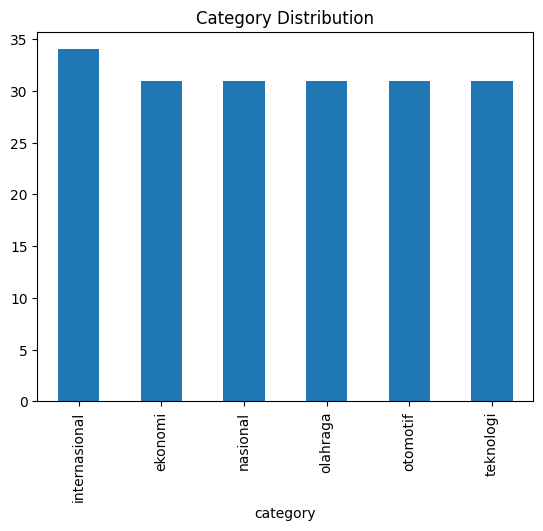

In [98]:
sample['category'].value_counts().plot(kind='bar', title='Category Distribution')

Plot distribusi dokumen dengan t-SNE

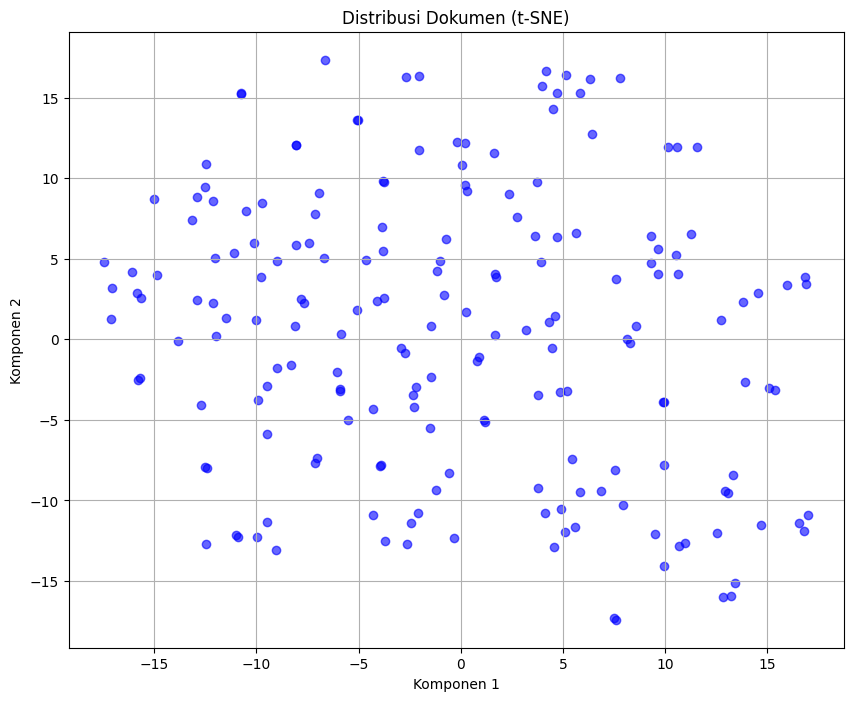

In [99]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_reduced = tsne.fit_transform(X.toarray())

plt.figure(figsize=(10, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.6, color='blue')
plt.title('Distribusi Dokumen (t-SNE)')
plt.xlabel('Komponen 1')
plt.ylabel('Komponen 2')
plt.grid(True)
plt.show()

Visualisasi word cloud semua dokumen

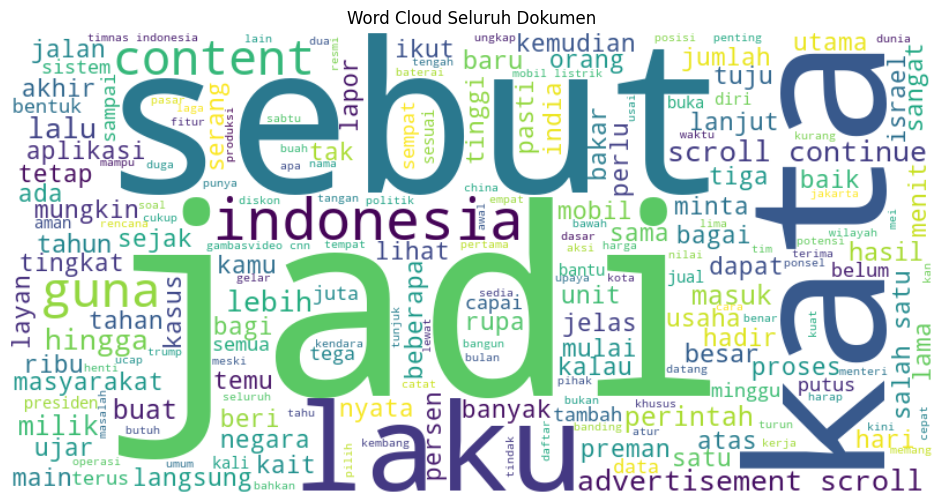

In [100]:
all_text = ' '.join(sample['cleaned_text'].tolist())

word_cloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud Seluruh Dokumen")
plt.show()

In [101]:
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt

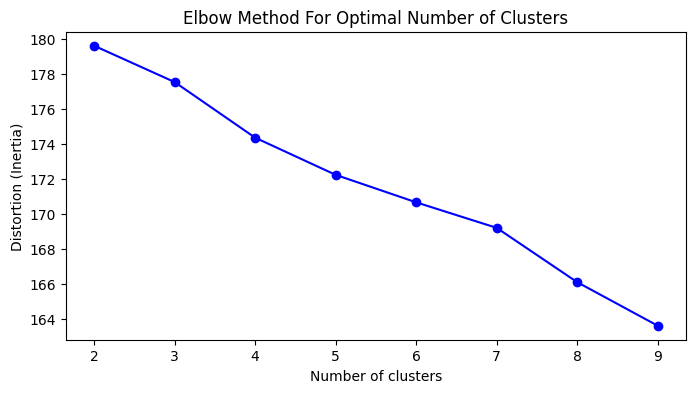

In [102]:
distortions = []
K = range(2, 10)
n_init = 13

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

# Plot elbow method
plt.figure(figsize=(8, 4))
plt.plot(K, distortions, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

In [103]:
num_clusters = 8
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X)
sample['k_means_cluster'] = clusters

In [104]:
def get_top_words(cluster_center, vectorizer, n=10):
    features = vectorizer.get_feature_names_out()
    top_indices = cluster_center.argsort()[-n:][::-1]
    return [features[i] for i in top_indices]

In [105]:
print("Top Keywords per cluster:")
for i, center in enumerate(kmeans.cluster_centers_):
    print(f"Cluster {i}: {get_top_words(center, vectorizer)}")

Top Keywords per cluster:
Cluster 0: ['aksi', 'sebut', 'ojol', 'whatsapp', 'aplikator', 'kemudi', 'prabowo', 'tindak', 'kamu', 'laku']
Cluster 1: ['bank', 'diskon', 'transmart', 'harga', 'mega', 'aplikasi', 'allo', 'persen', 'kamu', 'belanja']
Cluster 2: ['india', 'kasta', 'trump', 'tempur', 'kerja', 'gates', 'uea', 'jet', 'pakistan', 'sensus']
Cluster 3: ['mobil', 'bakar', 'unit', 'listrik', 'jemaah', 'baterai', 'haji', 'motor', 'jadi', 'saudi']
Cluster 4: ['paus', 'leo', 'xiv', 'thailand', 'prabowo', 'resmi', 'vatikan', 'lantik', 'nobat', 'pdip']
Cluster 5: ['main', 'indonesia', 'timnas', 'jadi', 'inter', 'laga', 'city', 'gol', 'menit', 'jokowi']
Cluster 6: ['ukraina', 'rusia', 'halal', 'tukar', 'orang', 'khan', 'cakung', 'kata', 'sepakat', 'golkar']
Cluster 7: ['israel', 'gaza', 'serang', 'hamas', 'militer', 'lebanon', 'gencat', 'senjata', 'warga', 'tewas']


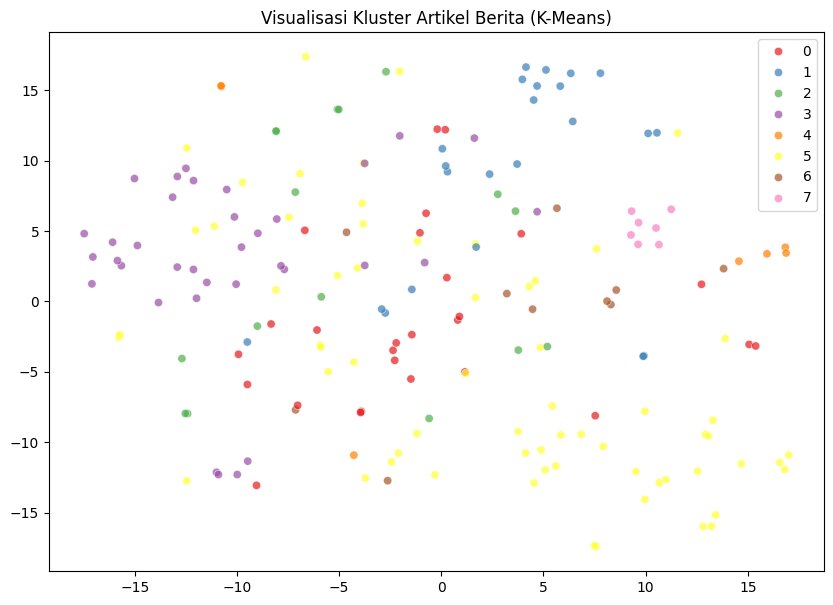

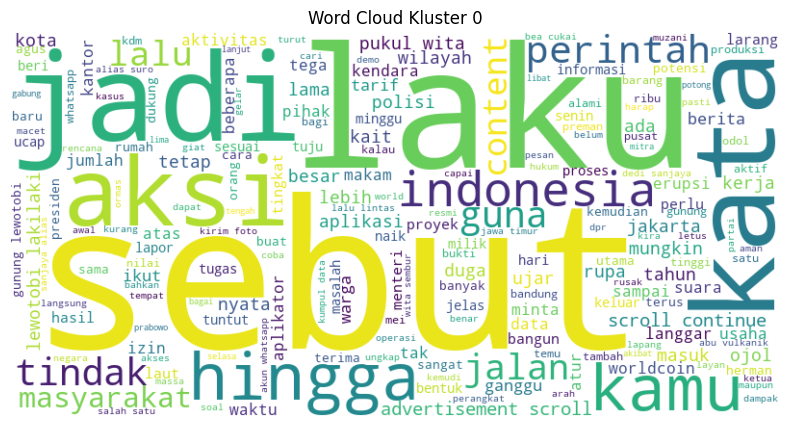

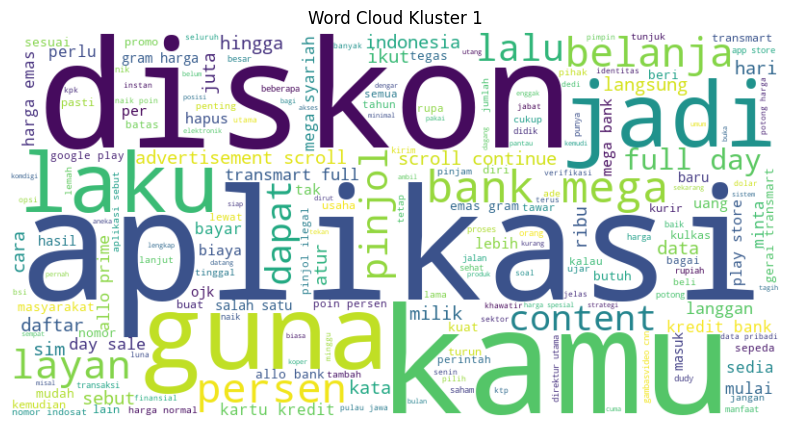

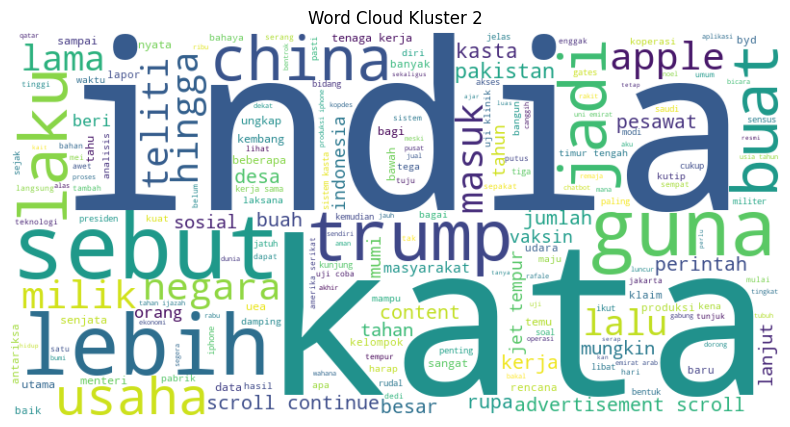

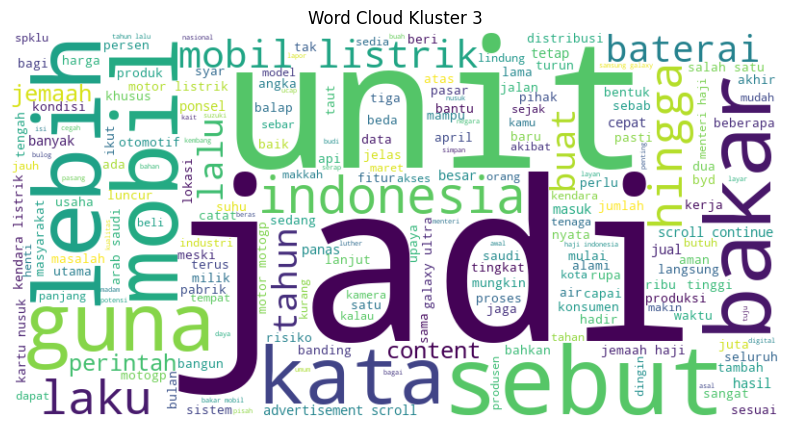

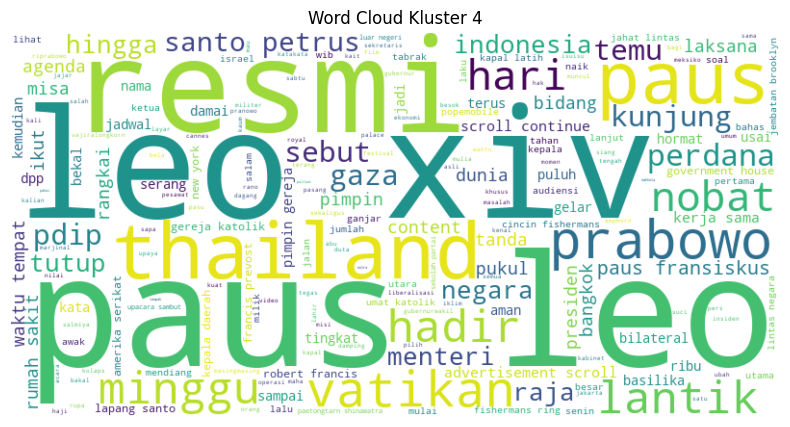

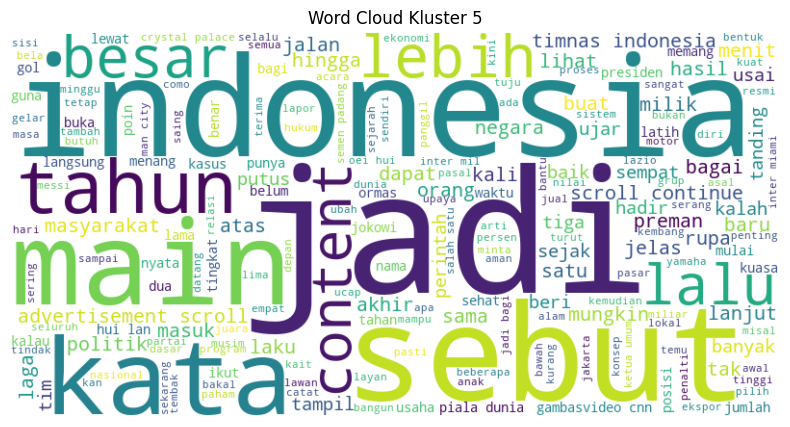

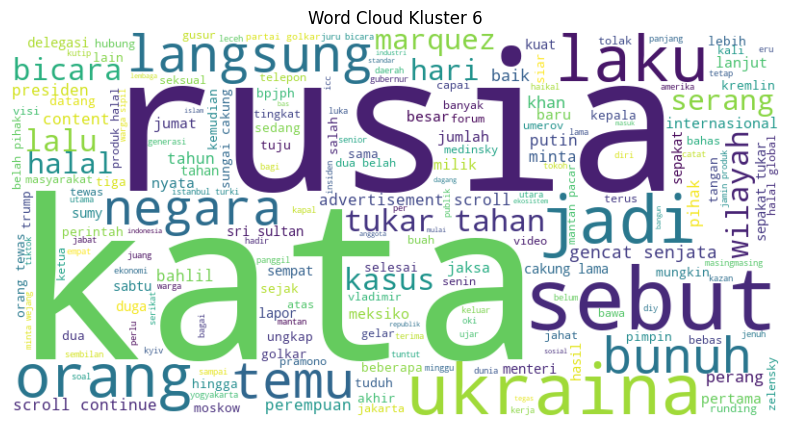

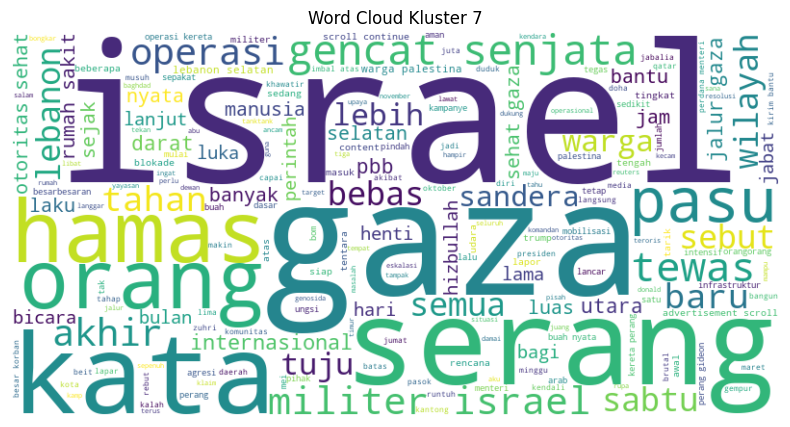

In [106]:
from sklearn.manifold import TSNE
import seaborn as sns
from wordcloud import WordCloud

# Reduksi dimensi dengan t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_reduced = tsne.fit_transform(X.toarray())

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=clusters, palette='Set1', alpha=0.7)
plt.title("Visualisasi Kluster Artikel Berita (K-Means)")
plt.show()

# --- Word Cloud untuk Tiap Kluster ---
for cluster_num in range(num_clusters):
    cluster_comments = sample[sample['k_means_cluster'] == cluster_num]['cleaned_text']
    text = ' '.join(cluster_comments.tolist())
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Word Cloud Kluster {cluster_num}')
    plt.show()

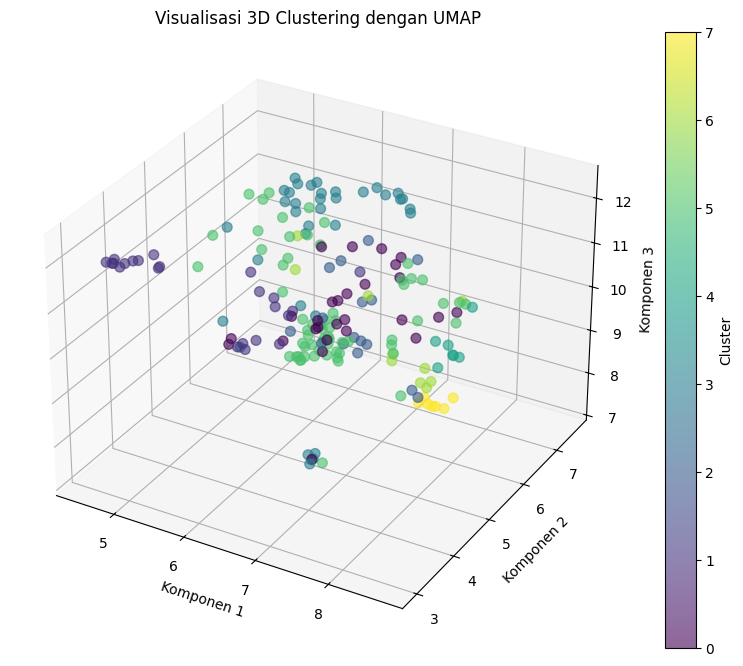

In [107]:
from umap import UMAP
umap_3d = UMAP(n_components=3)
X_umap_3d = umap_3d.fit_transform(X)

# Plot 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_umap_3d[:, 0], 
    X_umap_3d[:, 1], 
    X_umap_3d[:, 2], 
    c=clusters, 
    cmap='viridis', 
    s=50, 
    alpha=0.6
)

# Tambahkan colorbar
plt.colorbar(scatter, ax=ax, label='Cluster')

# Label sumbu
ax.set_xlabel('Komponen 1')
ax.set_ylabel('Komponen 2')
ax.set_zlabel('Komponen 3')
ax.set_title('Visualisasi 3D Clustering dengan UMAP')

plt.show()

Metrik Evaluasi Clustering

In [108]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

print(f"Silhouette Score: {silhouette_score(X, clusters):.4f}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X.toarray(), clusters):.4f}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X.toarray(), clusters):.4f}")

Silhouette Score: 0.0265
Calinski Harabasz Score: 2.4320
Davies Bouldin Score: 4.8511


Distribusi jumlah dokumen tiap cluster

<Axes: title={'center': 'Cluster Distribution'}, xlabel='k_means_cluster'>

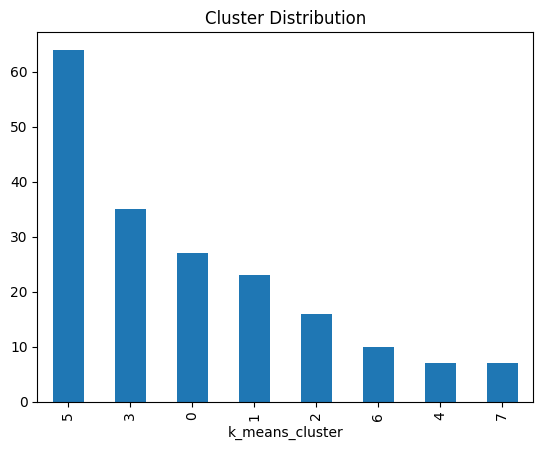

In [109]:
sample['k_means_cluster'].value_counts().plot(kind='bar', title='Cluster Distribution')

Contoh dokumen dalam tiap cluster

In [110]:
for cluster_id in sorted(sample['k_means_cluster'].unique()):
    print(f"\n=== Kluster {cluster_id} ===")
    print(sample[sample['k_means_cluster']==cluster_id]['text'].head(10))


=== Kluster 0 ===
13    Daftar 5 Tuntutan Ojol Dalam Demo Besar-Matika...
15    Ara Heran 70 Kepala Daerah Tak Patuh Aturan Pa...
18    Bahlil Minta Restu Prabowo Evaluasi Izin Blok ...
22    Istana: Investor Takut Masuk Akibat Premanisme...
66    Hasan Nasbi PCO Jelaskan Maksud Prabowo soal S...
67    Polisi Ungkap Bisnis Narkoba Pasutri Libatkan ...
69    6.000 Ojol Surabaya Siap Demo Besar-besaran Be...
70    Battle Sound Horeg di Pasuruan Dikecam, Polisi...
72    Demo Ojol 20 Mei, Polisi Siapkan Rekayasa Lalu...
74    Muzani ke Kader Gerindra: Buktikan Rakyat Ingi...
Name: text, dtype: object

=== Kluster 1 ===
1     Kulkas Harga Miring Jadi Incaran di Transmart ...
2     Profil Anggoro Eko Cahyo, dari Bos BPJS Hijrah...
6     Transmart Full Day Sale, Aneka Barang Elektron...
7     Transmart Full Day Sale, Koper Diskon Gede-ged...
8     Menhub soal Ojol Minta Biaya Aplikasi Jadi 10 ...
10    Harga Emas Antam Melesat Rp23 Ribu Jadi Rp1,89...
14    Transmart Full Day Sale, Sepeda Di

In [111]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

epsilon_candidates = np.arange(0.5, 4, 0.2)
best_score = -1
best_epsilon = None

min_samples = 3

for eps in epsilon_candidates:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    labels = dbscan.labels_
    
    # Hitung silhouette score (abaikan noise/kluster -1 jika ada)
    if len(np.unique(labels)) > 1:  # Minimal 2 kluster
        score = silhouette_score(X, labels)
        if score > best_score:
            best_score = score
            best_epsilon = eps

print(f"Best epsilon: {best_epsilon} (Silhouette Score: {best_score:.2f})")

Best epsilon: 1.0999999999999999 (Silhouette Score: 0.06)


In [112]:
dbscan = DBSCAN(eps=1.0999999999999999, min_samples=min_samples).fit(X)
clusters = dbscan.labels_
sample['dbscan_cluster'] = clusters

In [113]:
print(f"Silhouette Score: {silhouette_score(X, clusters):.4f}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X.toarray(), clusters):.4f}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X.toarray(), clusters):.4f}")

Silhouette Score: 0.0602
Calinski Harabasz Score: 2.9570
Davies Bouldin Score: 2.0138


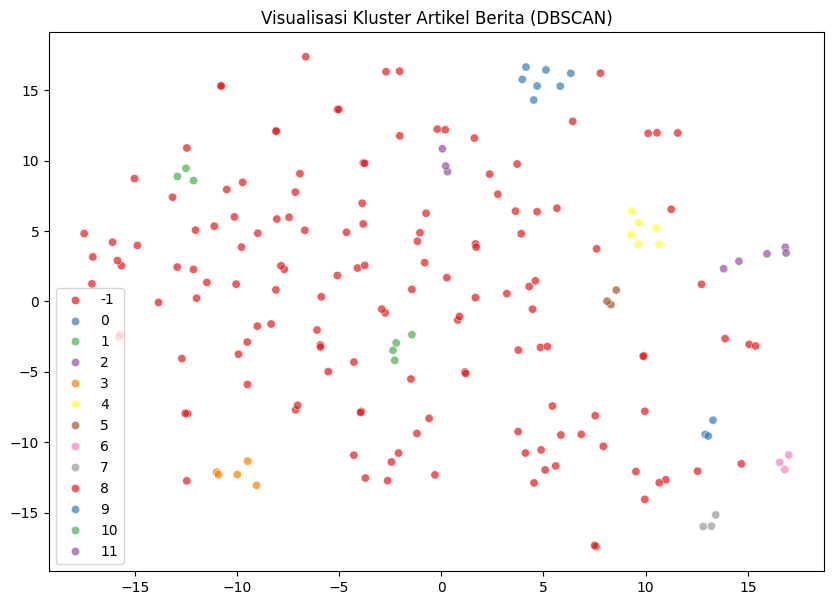

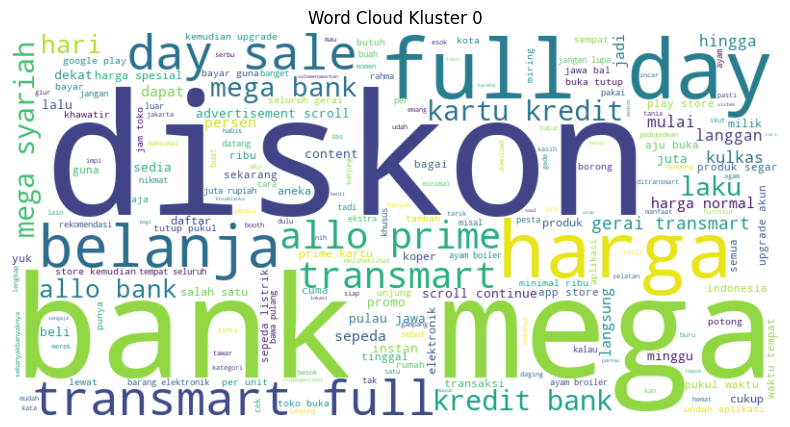

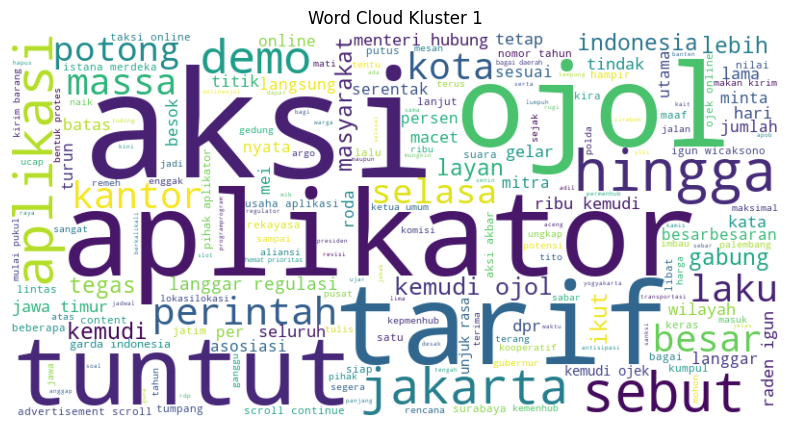

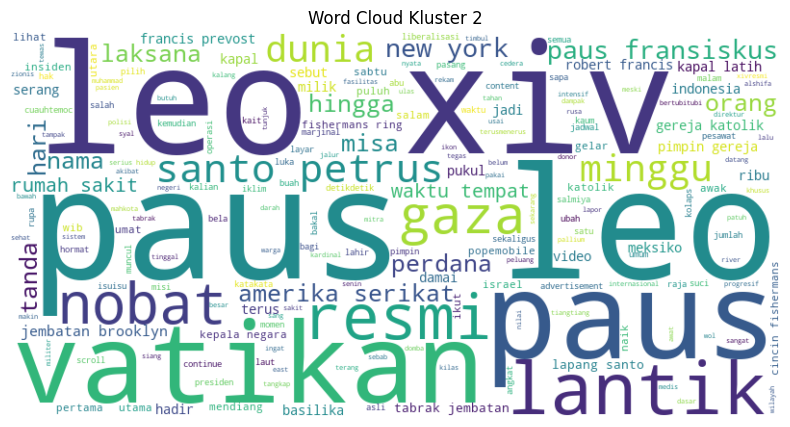

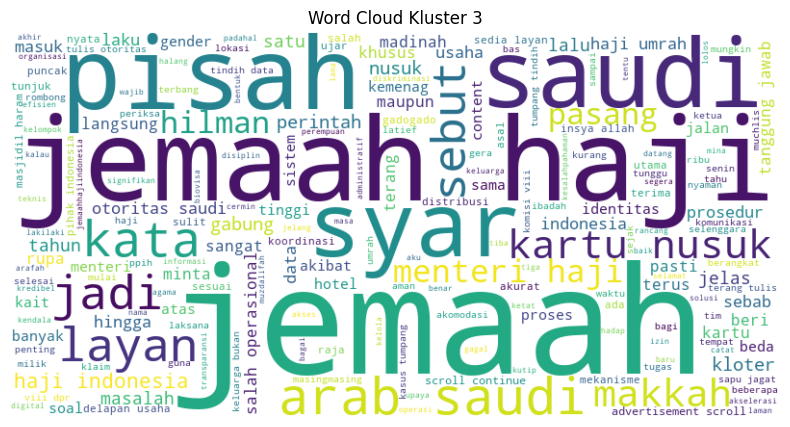

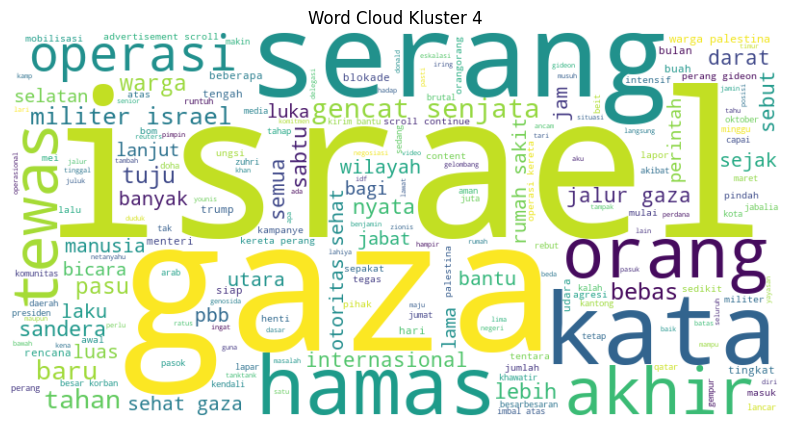

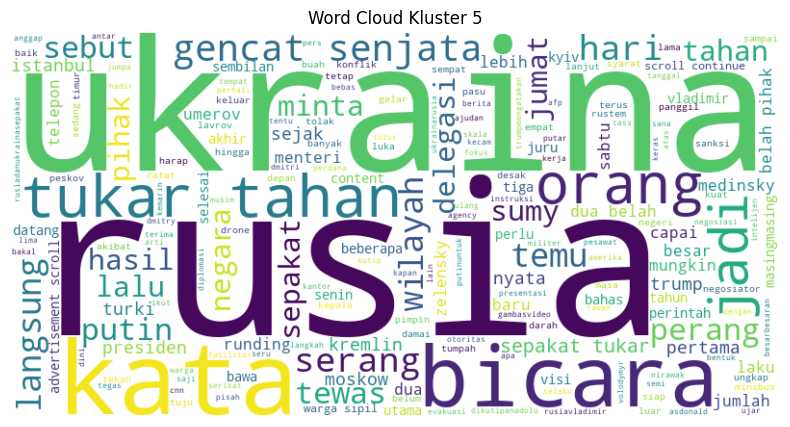

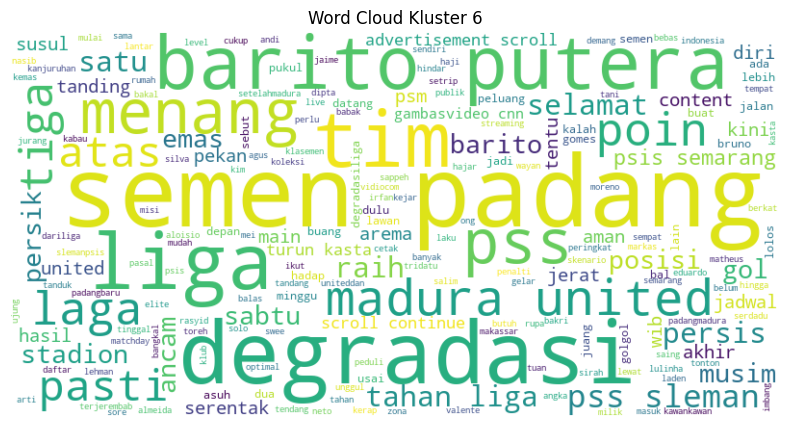

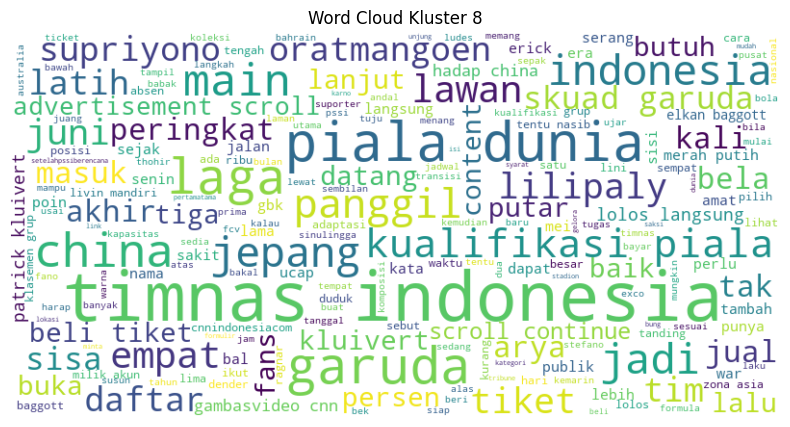

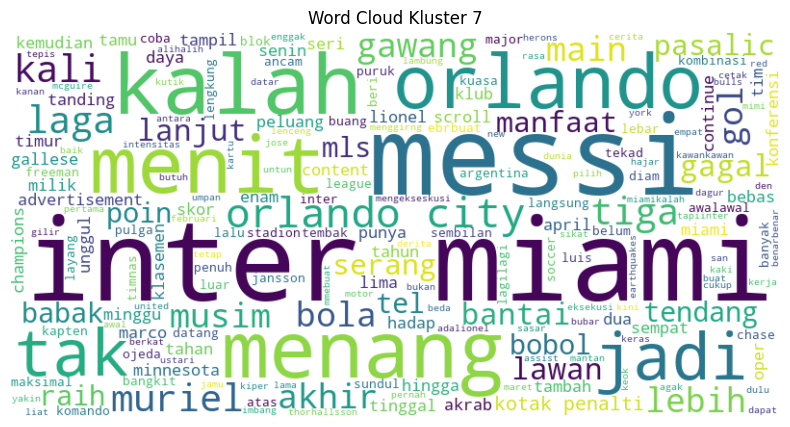

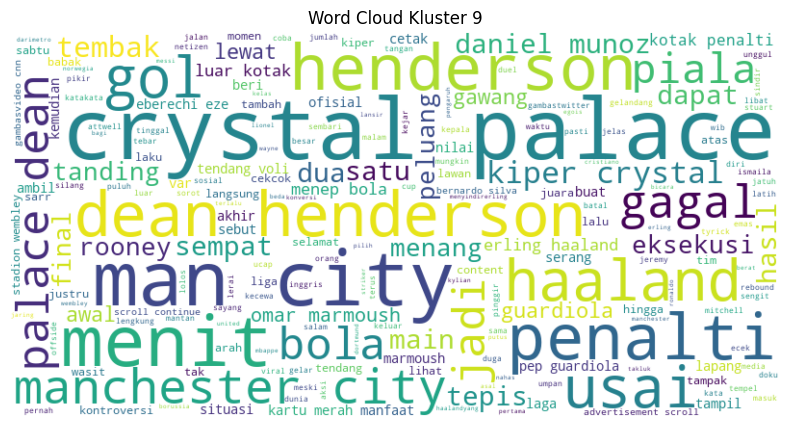

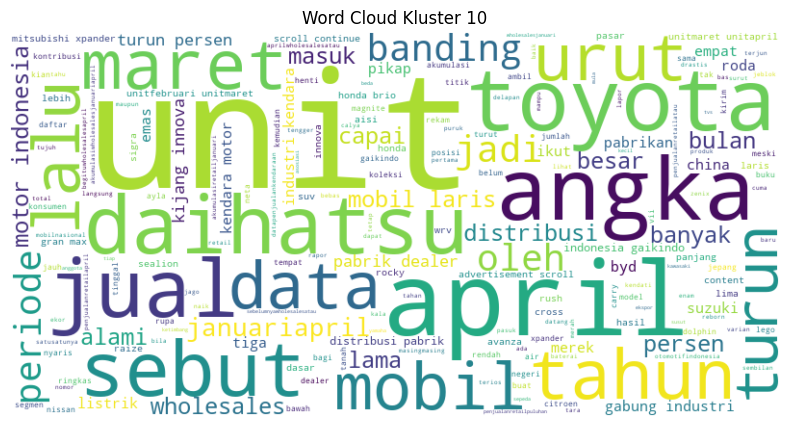

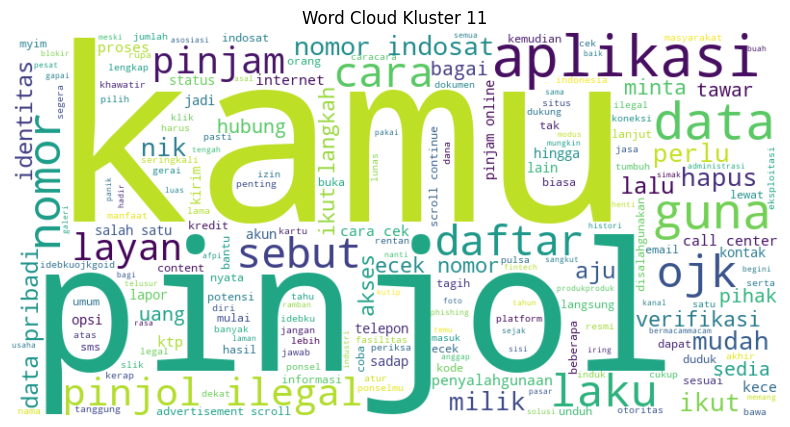

In [114]:
# Reduksi dimensi dengan t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_reduced = tsne.fit_transform(X.toarray())

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=clusters, palette='Set1', alpha=0.7)
plt.title("Visualisasi Kluster Artikel Berita (DBSCAN)")
plt.show()

# --- Word Cloud untuk Tiap Kluster ---
for cluster_num in sample['dbscan_cluster'].unique():
    if cluster_num == -1:  # Skip noise points
        continue
    cluster_comments = sample[sample['dbscan_cluster'] == cluster_num]['cleaned_text']
    text = ' '.join(cluster_comments.tolist())
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Word Cloud Kluster {cluster_num}')
    plt.show()

In [116]:
for cluster_id in sorted(sample['dbscan_cluster'].unique()):
    print(f"\n=== Kluster {cluster_id} ===")
    print(sample[sample['dbscan_cluster']==cluster_id]['text'].head(10))


=== Kluster -1 ===
0     Vale Indonesia Tebar Dividen Rp571 M PTValeInd...
2     Profil Anggoro Eko Cahyo, dari Bos BPJS Hijrah...
3     Prisma Luncurkan Brin Grande LED, Gandeng Kara...
4     Zulhas Ungkap Manfaat Kopdes: Pemuda Gak Perlu...
5     Pengusaha Sebut Ekspor Beras 2.000 Ton Tak Mas...
8     Menhub soal Ojol Minta Biaya Aplikasi Jadi 10 ...
9     Astra Catat Valuasi Ekspor UMKM Rp349 M dalam ...
10    Harga Emas Antam Melesat Rp23 Ribu Jadi Rp1,89...
11    Hadiri Kazan Forum, Bos BPJPH Perkuat RI di Ek...
12    Cara Bulog Menjaga Kualitas Beras di Tengah Se...
Name: text, dtype: object

=== Kluster 0 ===
1     Kulkas Harga Miring Jadi Incaran di Transmart ...
6     Transmart Full Day Sale, Aneka Barang Elektron...
7     Transmart Full Day Sale, Koper Diskon Gede-ged...
14    Transmart Full Day Sale, Sepeda Diskonnya Gede...
20    Transmart Full Day Sale, Harga Ayam Broiler Mu...
24    Buah Segar Hingga Ayam Boiler Diserbu di Momen...
29    Siapkan Daftar Belanja, Transmart

In [115]:
sample.head()

title  \
0               Vale Indonesia Tebar Dividen Rp571 M   
1  Kulkas Harga Miring Jadi Incaran di Transmart ...   
2  Profil Anggoro Eko Cahyo, dari Bos BPJS Hijrah...   
3  Prisma Luncurkan Brin Grande LED, Gandeng Kara...   
4  Zulhas Ungkap Manfaat Kopdes: Pemuda Gak Perlu...   

                                                link category  \
0  https://www.cnnindonesia.com/ekonomi/202505171...  ekonomi   
1  https://www.cnnindonesia.com/ekonomi/202505181...  ekonomi   
2  https://www.cnnindonesia.com/ekonomi/202505161...  ekonomi   
3  https://www.cnnindonesia.com/ekonomi/202505191...  ekonomi   
4  https://www.cnnindonesia.com/ekonomi/202505162...  ekonomi   

                                             content  date  \
0  PTValeIndonesia Tbk membagikandividentunai seb...   NaN   
1  Transmart Full Day Salemenawarkan berbagai pro...   NaN   
2  Rapat Umum Pemegang Saham Tahunan (RUPST) PT B...   NaN   
3  Prisma Advertising meluncurkan Brin Grande LED...   NaN   
4  Menteri Koordinator Bidang PanganZulkifli Hasa...   NaN   

                                                text  \
0  Vale Indonesia Tebar Dividen Rp571 M PTValeInd...   
1  Kulkas Harga Miring Jadi Incaran di Transmart ...   
2  Profil Anggoro Eko Cahyo, dari Bos BPJS Hijrah...   
3  Prisma Luncurkan Brin Grande LED, Gandeng Kara...   
4  Zulhas Ungkap Manfaat Kopdes: Pemuda Gak Perlu...   

                                        cleaned_text  k_means_cluster  \
0  vale indonesia tebar dividen ptvaleindonesia t...                5   
1  kulkas harga miring jadi incar transmart full ...                1   
2  profil anggoro eko cahyo bos bpjs hijrah jadi ...                1   
3  prisma luncur brin grande led gandeng karakter...                5   
4  zulhas ungkap manfaat kopdes pemuda gak perlu ...                2   

   dbscan_cluster  
0              -1  
1               0  
2              -1  
3              -1  
4              -1